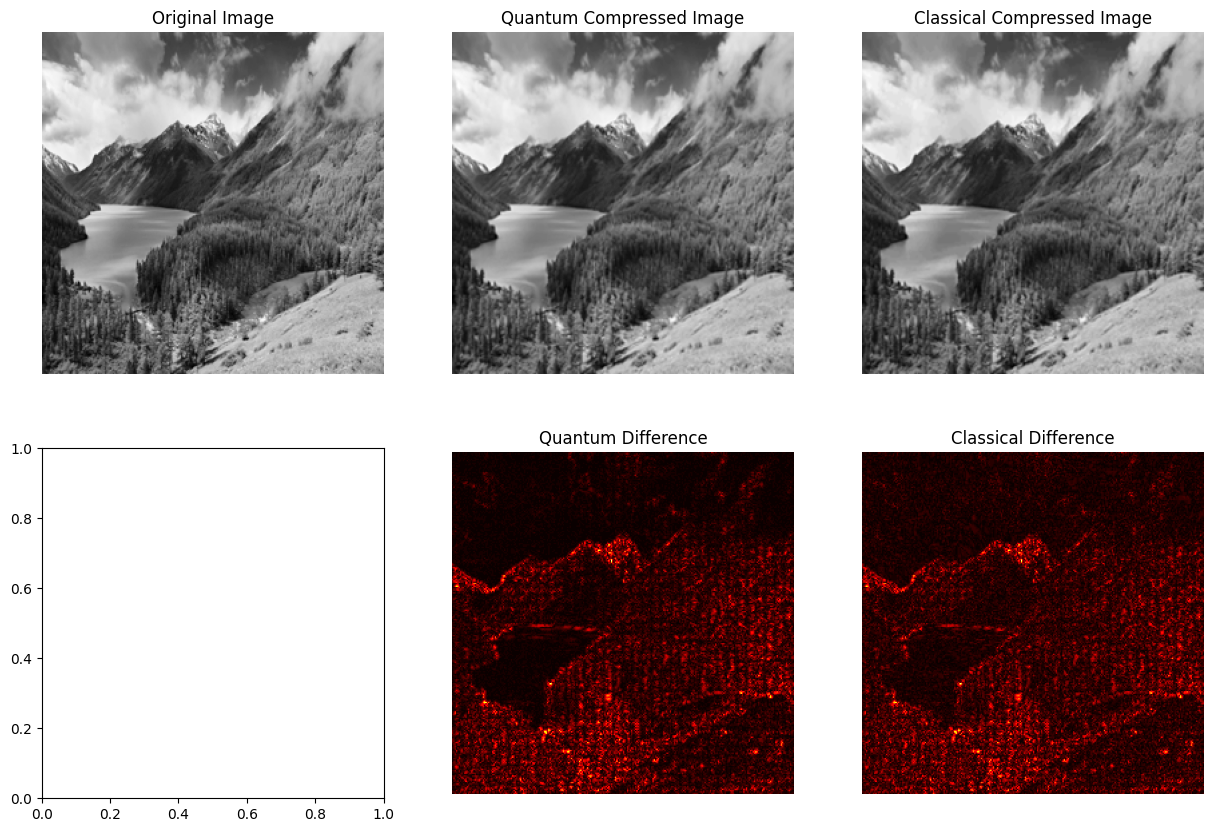

Original Image Size: 456.79 KB
Quantum State Dimensions: (4294967296,)
Number of Qubits Used: 32
Quantum PSNR: 35.35, Quantum SSIM: 0.97
Classical PSNR: 34.90, Classical SSIM: 0.97


In [5]:
# Install necessary libraries
!pip install pennylane pennylane-qiskit matplotlib numpy pillow scikit-learn scikit-image

# Import required libraries
import pennylane as qml
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import os

# Define the device for quantum simulation
num_qubits = 32  # Number of qubits optimized for clarity and compression
dev = qml.device("default.qubit", wires=num_qubits)

# Quantum circuit for encoding pixel data using amplitude encoding
@qml.qnode(dev)
def encode_image_amplitude(image_vector):
    """
    Quantum amplitude encoding for an image vector into quantum states.
    Efficiently uses fewer qubits while retaining clarity.
    """
    # Pad the vector to ensure length matches 2^num_qubits
    target_length = 2 ** num_qubits
    padded_vector = np.pad(image_vector, (0, target_length - len(image_vector)), mode="constant")

    # Normalize the padded vector
    norm = np.linalg.norm(padded_vector)
    if norm == 0:
        raise ValueError("Image vector cannot be all zeros for quantum encoding.")
    normalized_vector = padded_vector / norm

    # Encode using amplitude encoding
    qml.AmplitudeEmbedding(features=normalized_vector, wires=range(num_qubits), normalize=True)

    return qml.state()

def preprocess_image(image_path, size=(220, 220)):
    """
    Resize the image, convert to grayscale, and flatten for encoding.
    """
    # Load and resize the image
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image_resized = image.resize(size)  # Resize to target dimensions
    image_array = np.array(image_resized).astype(float) / 255.0  # Normalize pixel values

    # Flatten the image into a vector
    flattened_vector = image_array.flatten()

    return flattened_vector, image_resized

# Quantum compression simulation
def quantum_image_compression(image_path, size=(220, 220)):
    """
    Simulate optimized quantum image compression while retaining clarity.
    """
    # Preprocess the image
    image_vector, processed_image = preprocess_image(image_path, size=size)

    # Simulate quantum encoding using amplitude encoding
    quantum_state = encode_image_amplitude(image_vector)

    # Return quantum state and the processed image for visualization
    return quantum_state, processed_image

# Compare classical compression
def classical_compression(image_path, display_size=(220, 220)):
    """
    Perform classical compression using JPEG with different quality settings.
    """
    # Compress using JPEG at a high compression level (low quality)
    compressed_path = "/content/compressed_image.jpg"
    original_image = Image.open(image_path)
    original_size = os.path.getsize(image_path)

    # Save with high compression
    original_image.save(compressed_path, "JPEG", quality=15)
    compressed_size = os.path.getsize(compressed_path)

    # Reload the compressed image for display and resize
    compressed_image = Image.open(compressed_path).convert("L")
    compressed_image_resized = compressed_image.resize(display_size)

    return original_size, compressed_size, compressed_image_resized, compressed_path

# Display images and differences
def display_images_and_differences(original_image, quantum_image, classical_image, display_size=(256, 256)):
    """
    Display the original, quantum-compressed, and classically compressed images
    along with their pixel-wise differences from the original image.
    """
    # Resize all images to the same size for display
    original_resized = original_image.resize(display_size)
    quantum_resized = quantum_image.resize(display_size)
    classical_resized = classical_image.resize(display_size)

    # Calculate pixel-wise differences
    original_array = np.array(original_resized).astype(float)
    quantum_array = np.array(quantum_resized).astype(float)
    classical_array = np.array(classical_resized).astype(float)

    quantum_diff = np.abs(original_array - quantum_array)
    classical_diff = np.abs(original_array - classical_array)

    # Display images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Original image
    axes[0, 0].imshow(original_resized, cmap="gray")
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")

    # Quantum-compressed image
    axes[0, 1].imshow(quantum_resized, cmap="gray")
    axes[0, 1].set_title("Quantum Compressed Image")
    axes[0, 1].axis("off")

    # Classical compressed image
    axes[0, 2].imshow(classical_resized, cmap="gray")
    axes[0, 2].set_title("Classical Compressed Image")
    axes[0, 2].axis("off")

    # Quantum difference
    axes[1, 1].imshow(quantum_diff, cmap="hot")
    axes[1, 1].set_title("Quantum Difference")
    axes[1, 1].axis("off")

    # Classical difference
    axes[1, 2].imshow(classical_diff, cmap="hot")
    axes[1, 2].set_title("Classical Difference")
    axes[1, 2].axis("off")

    plt.show()

    return original_resized, quantum_resized, classical_resized

# Calculate metrics
def calculate_metrics(original_image, compressed_image):
    """
    Calculate PSNR and SSIM between original and compressed images.
    """
    original_array = np.array(original_image).astype(float)
    compressed_array = np.array(compressed_image).astype(float)

    # Calculate PSNR and SSIM
    psnr_value = psnr(original_array, compressed_array, data_range=255)
    ssim_value = ssim(original_array, compressed_array, data_range=255)

    return psnr_value, ssim_value

# Main function
if __name__ == "__main__":
    # Path to your image (upload to Colab)
    image_path = "/content/sample-image.jpg"  # Update with your uploaded image path

    # Load the original image
    original_image = Image.open(image_path).convert("L")

    # Perform quantum compression
    quantum_state, quantum_compressed_image = quantum_image_compression(image_path)

    # Perform classical compression for comparison
    original_size, compressed_size, classical_image, compressed_path = classical_compression(image_path)

    # Calculate quantum compressed size
    quantum_amplitude_count = len(quantum_state)  # Number of amplitudes used
    quantum_compressed_size = quantum_amplitude_count * 16  # Each amplitude uses 16 bytes

    # Display all images and differences
    original_resized, quantum_resized, classical_resized = display_images_and_differences(
        original_image, quantum_compressed_image, classical_image
    )

    # Calculate and display metrics
    quantum_psnr, quantum_ssim = calculate_metrics(original_resized, quantum_resized)
    classical_psnr, classical_ssim = calculate_metrics(original_resized, classical_resized)

    print(f"Original Image Size: {original_size / 1024:.2f} KB")
    print(f"Quantum State Dimensions: {quantum_state.shape}")
    print(f"Number of Qubits Used: {num_qubits}")
    print(f"Quantum PSNR: {quantum_psnr:.2f}, Quantum SSIM: {quantum_ssim:.2f}")
    print(f"Classical PSNR: {classical_psnr:.2f}, Classical SSIM: {classical_ssim:.2f}")